# Forecast Variance with ARCH-types family

## Here we find the best ARCH-types family models from the MCS algorithm selection

In [2]:
from arch import arch_model
import datetime as dt
from libraries.Cryptov2 import Cryptocurrency
import pandas as pd
import numpy as np
import datetime
import arch
import matplotlib.pyplot as plt
from arch.univariate import arch_model
from arch.univariate import ARCH, GARCH, EGARCH, MIDASHyperbolic
from arch.univariate import ConstantMean, ZeroMean
from arch.univariate import Normal, SkewStudent, StudentsT
%matplotlib inline

In [4]:
BTC = Cryptocurrency('BTC', data=None ,url = 'https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end=20191001')
IOTA = Cryptocurrency('IOTA', data=None ,url = 'https://coinmarketcap.com/currencies/iota/historical-data/?start=20130428&end=20191001')
ETH = Cryptocurrency('ETH', data=None ,url = 'https://coinmarketcap.com/currencies/ethereum/historical-data/?start=20130428&end=20191001')
EOS = Cryptocurrency('EOS', data=None ,url = 'https://coinmarketcap.com/currencies/eos/historical-data/?start=20130428&end=20191001')

Cryptocurrency V.0.3
Data for BTC already exists.
Reading...
Done! 2345 rows and 34 columns
Cryptocurrency V.0.3
Data for IOTA already exists.
Reading...
Done! 838 rows and 34 columns
Cryptocurrency V.0.3
Data for ETH already exists.
Reading...
Done! 1514 rows and 34 columns
Cryptocurrency V.0.3
Data for EOS already exists.
Reading...
Done! 820 rows and 34 columns


In [7]:
crypto_list = [BTC,IOTA,ETH,EOS]

In [8]:
# Compute the sizes of the cryptocurrencies
def get_training_test_size(crypto):
    training = len(crypto.data['log_returns']) * 5//6
    testing = len(crypto.data['log_returns']) - training
    return training,testing

In [2]:
# Check if all cryptos are ok in terms of lenght of observation
for each in crypto_list:
    print(f"{each.name} : {get_training_test_size(each)}")

NameError: name 'crypto_list' is not defined

In [3]:
# We check the index of (e.g. EOS)
EOS.data.index

NameError: name 'EOS' is not defined

In [11]:
for each in crypto_list:
    each.data['log_price'] = np.log(each.data['close'])
    each.data['pct_change'] = each.data['log_price'].diff()
    each.data['stdev14'] = each.data['pct_change'].rolling(window=14, center=False).std(ddof=0)
    each.data['stdev30'] = each.data['pct_change'].rolling(window=30, center=False).std(ddof=0)
    each.data['stdev60'] = each.data['pct_change'].rolling(window=60, center=False).std(ddof=0)

    each.data['hvol14'] = each.data['stdev14'] * (365**0.5) # Annualize.
    each.data['hvol30'] = each.data['stdev30'] * (365**0.5) # Annualize.
    each.data['hvol60'] = each.data['stdev60'] * (365**0.5) # Annualize.

    each.data['variance14'] = each.data['hvol14']**2
    each.data['variance30'] = each.data['hvol30']**2
    each.data['variance60'] = each.data['hvol60']**2

    each.data = each.data.dropna() # Remove rows with blank cells.
    each.data['returns'] = each.data['pct_change'] * 100

In [12]:
def find_best_model_who_minimize_mse(crypto, hvol='hvol14'):
    """Algorithm to find out the best model based on MSE.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    prediction = []
    mse_list = []
    returns = crypto.data['returns']
    am = ConstantMean(returns)
    
    # We define our models of interest
    model_list = ['ARCH', 'GARCH', 'EGARCH']
    dist_types = ['normal', 'studentst', 'skewstudent']
    
    p_list = range(1,10)
    q_list = range(1,10)
    previous_mse = 100
    previous_mse_in = 100
    previous_mse_out = 100
    previous_rmse_in = 100
    previous_rmse_out = 100
    previous_p = 0
    previous_q = 0
    previous_dist = "NaN"
    previous_model = "NaN"
    
    n_days = len(crypto.data.index) * 5 // 6
    last_date = dt.datetime(crypto.data.index[n_days].year,crypto.data.index[n_days].month,crypto.data.index[n_days].day)
    start_date = dt.datetime(crypto.data.index[0].year,crypto.data.index[0].month,crypto.data.index[0].day)
        
    for model in model_list:
        for dist in dist_types:
            
            # Our distribution
            if dist is 'normal':
                am.distribution = Normal()
            elif dist is 'studentst':
                am.distribution = StudentsT()
            elif dist is 'skewstudent':
                am.distribution = SkewStudent()
            
            
            for each_p in p_list:
                for each_q in p_list:
                    # We plot the series 
                    x2 = crypto.data[hvol]
                    
                    # Our volatility process
                    if model is "ARCH":
                        am.volatility = ARCH(p=each_p)
                    elif model is "GARCH":
                        am.volatility = GARCH(p=each_p, q=each_q)
                    elif model is "EGARCH":
                        am.volatility = EGARCH(p=each_p, q=each_q)

                    res = am.fit(disp="off", last_obs=last_date)
                    forecasts = res.forecast(horizon=1, start=start_date, method='analytic')
                    
                    x1 = np.sqrt(0.01*forecasts.variance)
                    x1 = x1['h.1']
                    
                    squared_error = (x1-x2)**2
                    # Compute error rate
                    MSE = squared_error.mean()
                    MSE_vol = MSE.std()
                    
                    prediction.append(x1)
                    mse_list.append(MSE)
                    
                    MSE_in = squared_error[:last_date].mean()
                    MSE_out = squared_error[last_date:].mean()
                    RMSE_in = np.sqrt(squared_error[:last_date].mean())
                    RMSE_out = np.sqrt(squared_error[last_date:].mean())
    
    
                    if previous_mse_out > MSE_out:
                        previous_mse_in = MSE_in
                        previous_mse_out = MSE_out
                        previous_rmse_in = RMSE_in
                        previous_rmse_out = RMSE_out
                        previous_q = each_q
                        previous_p = each_p
                        previous_model = model
                        previous_dist = dist
                        
                    print(f"MODEL : {model}\tdist :{dist}\t\tRMSE in {round(RMSE_in,4)}\tRMSE out {round(RMSE_out,4)}\tp:{each_p}\tp:{each_q}\t\t\tCurrent winning model : {previous_model}\tdist : {previous_dist}\t\tRMSE in{round(previous_rmse_in,5)}\t RMSE out{round(previous_rmse_out,5)}\tp:{previous_p}\tp:{previous_q}")
    print(f"BEST MODEL FOR {crypto.name}\tMODEL : {previous_model}\tdist : {previous_dist}\tp : {previous_p}\tq : {previous_q}\tRMSE in {round(previous_rmse_in,4)}\tRMSE out {round(previous_rmse_out,4)}")
    print("Done!")

In [13]:
def save_as_latex(res,vol_model,dist,crypto,p,q):
    beginningtex = """\\documentclass{report}
    \\usepackage{booktabs}
    \\begin{document}"""
    endtex = "\end{document}"

    f = open(f'../../paper/tables/{crypto.name}-{vol_model}-{dist}-{p}-{q}.tex', 'w')
    f.write(beginningtex)
    f.write(res.summary().as_latex())
    f.write(endtex)
    f.close()

In [4]:
def compute_mse_and_volatility(vol_model,dist,crypto,p,q):
    """Provided a model we compute a graph it.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    n_days = len(crypto.data.index) * 5 // 6
    last_date = dt.datetime(crypto.data.index[n_days].year,crypto.data.index[n_days].month,crypto.data.index[n_days].day)
    start_date = dt.datetime(crypto.data.index[0].year,crypto.data.index[0].month,crypto.data.index[0].day)
    print(f"start_date {start_date}")
    
    returns = crypto.data['log_returns'] * 100

    am = ConstantMean(returns)
    
    # Our distribution
    if dist is 'normal':
        am.distribution = Normal()
    elif dist is 'studentst':
        am.distribution = StudentsT()
    elif dist is 'skewstudent':
        am.distribution = SkewStudent()

    # Our volatility process
    if vol_model is "ARCH":
        am.volatility = ARCH(p=p)
    elif vol_model is "GARCH":
        am.volatility = GARCH(p=p, q=q)
    elif vol_model is "EGARCH":
        am.volatility = EGARCH(p=p, q=q)
    
    
    # We plot the series 
    x2 = crypto.data['hvol14']
    x3 = crypto.data['hvol30']
    x4 = crypto.data['hvol60']

    res = am.fit(disp="off", last_obs=last_date)
    
    save_as_latex(res,vol_model,dist,crypto,p,q)
    forecasts = res.forecast(horizon=1, start=start_date, method='analytic')
    
    x1 = np.sqrt(0.01*forecasts.variance)
    x1 = x1['h.1']
    t1 = x1.index
    t2 = x2.index
    
    squared_error = (x1-x2)**2
    
    MSE_in = squared_error[:last_date].mean()
    MSE_out = squared_error[last_date:].mean()
    RMSE_in = np.sqrt(squared_error[:last_date].mean())
    RMSE_out = np.sqrt(squared_error[last_date:].mean())
    
    
    fig, axs = plt.subplots(2, 1, figsize=(10,6))
    
    textstr = f'MSE all {round(np.mean((x1-x2)**2),4)}\nMSE in={round(MSE_in,4)}\nMSE out={round(MSE_out,4)}\nRMSE in={round(RMSE_in,4)}\nRMSE out={round(RMSE_out,4)}'

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    axs[1].text(0.05, 0.95, textstr, transform=axs[1].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

    axs[0].set_title(f'{crypto.name} - {vol_model} - {dist} - p : {p} q : {q}')
    axs[0].plot(t1[:n_days],x1[:n_days], label='Forceasted volatility in', color="blue")
    axs[0].plot(t1[n_days:],x1[n_days:], label='Forceasted volatility out', color="black")
    axs[0].plot(t2,x2, label='Historical volatility 14 ', color="green", alpha=0.8)
    
    axs[0].set_xlabel('time')
    axs[0].set_ylabel('Volatility : $\hat{\sigma}$')
    axs[0].grid(True)
    axs[0].legend()

    axs[1].set_title('Squared Error Evolution $(\hat{\sigma}_{t}-\sigma_{t})^2$')
    axs[1].fill_between(t1, squared_error, label='Squared Error', color="green", alpha=0.5)
    axs[1].set_xlabel('time')
    axs[1].set_ylabel('squared error')
    axs[1].grid(True)
    axs[1].legend()

    fig.tight_layout()
    plt.savefig(f"../../paper/img/forecasts/ts/{crypto.name}/{crypto.name}-{vol_model}-{dist}-{p}-{q}.png")
    plt.show()
    MSE_in_rep = np.repeat(MSE_in, len(x1))
    MSE_out_rep = np.repeat(MSE_out, len(x1))
    RMSE_in_rep = np.repeat(RMSE_in, len(x1))
    RMSE_out_rep = np.repeat(RMSE_out, len(x1))
    
    df = pd.DataFrame({'sigma_hat':x1,'hvol14':x2, 'MSE_in': MSE_in_rep, 'MSE_out': MSE_out_rep, 'RMSE_in': RMSE_in_rep, 'RMSE_out': RMSE_out_rep,
                       'squared_error': squared_error, 'momentum': crypto.data['momentum'], 'rsi': crypto.data['rsi'], 
                       'macd': crypto.data['macd'],'bblb': crypto.data['boll_bands_lower_band'],'bbub': crypto.data['boll_bands_upper_band'], 'returns': crypto.data['returns'] }, index=t1)
    print(f"../../paper/img/forecasts/ts/{crypto.name}/{crypto.name}-{vol_model}-{dist}-{p}-{q}.png")
    df.to_csv(f"./models/ts/forecasts/{crypto.name}/{crypto.name}-{vol_model}-{dist}-{p}-{q}.csv")

In [64]:
# EGARCH p=8 q=4 skewstudent
# find_best_model_who_minimize_mse(BTC)

In [65]:
# EGARCH p=3 q=9 skewstudent
# find_best_model_who_minimize_mse(EOS)

In [66]:
# EGARCH p=4 q=4 skewstudent
# find_best_model_who_minimize_mse(ETH)

In [67]:
# EGARCH p=8 q=5 skewstudent
# find_best_model_who_minimize_mse(IOTA)

# Winner MCS
Here we compute the winning models from the previous MCS algorithm selection

start_date 2013-06-29 00:00:00


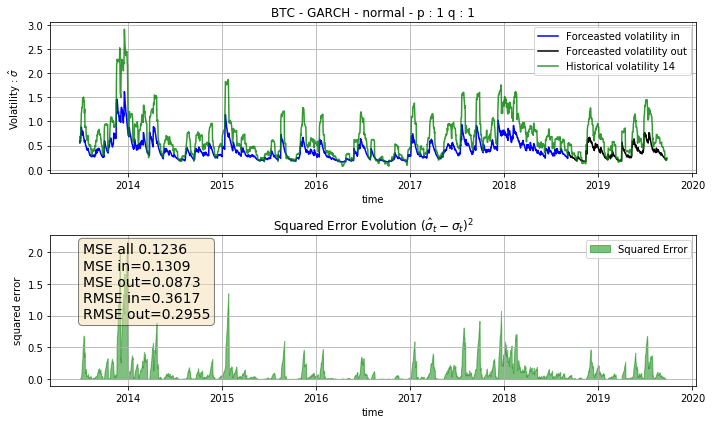

../../paper/img/forecasts/ts/BTC/BTC-GARCH-normal-1-1.png


In [68]:
compute_mse_and_volatility("GARCH",'normal',BTC,1,1)

start_date 2013-06-29 00:00:00


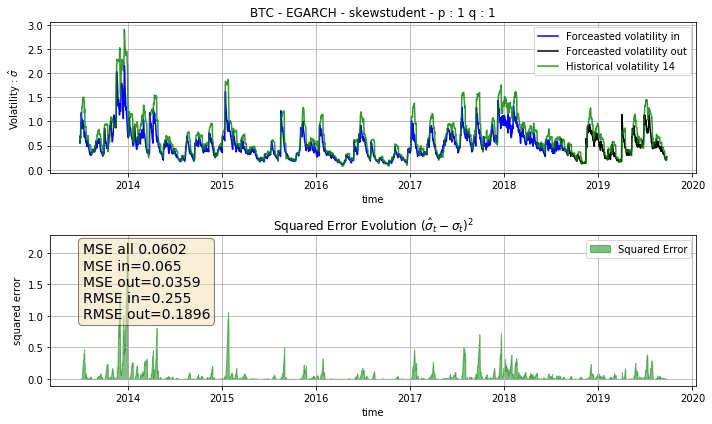

../../paper/img/forecasts/ts/BTC/BTC-EGARCH-skewstudent-1-1.png


In [69]:
compute_mse_and_volatility("EGARCH",'skewstudent',BTC,1,1)

start_date 2015-10-08 00:00:00


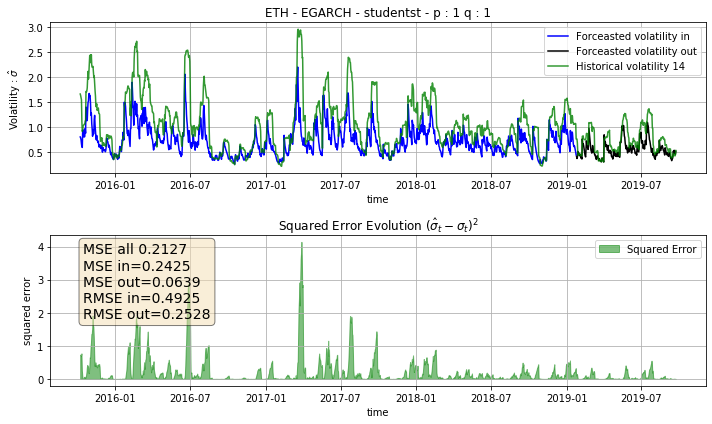

../../paper/img/forecasts/ts/ETH/ETH-EGARCH-studentst-1-1.png


In [70]:
compute_mse_and_volatility("EGARCH",'studentst',ETH,1,1)

start_date 2015-10-08 00:00:00


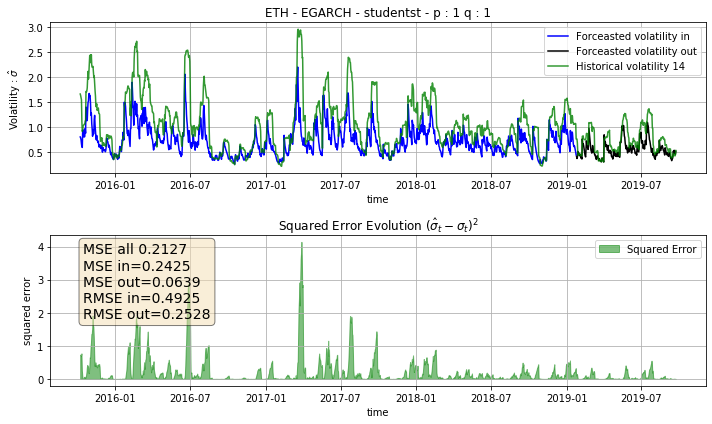

../../paper/img/forecasts/ts/ETH/ETH-EGARCH-studentst-1-1.png


In [71]:
compute_mse_and_volatility("EGARCH",'studentst',ETH,1,1)

start_date 2015-10-08 00:00:00


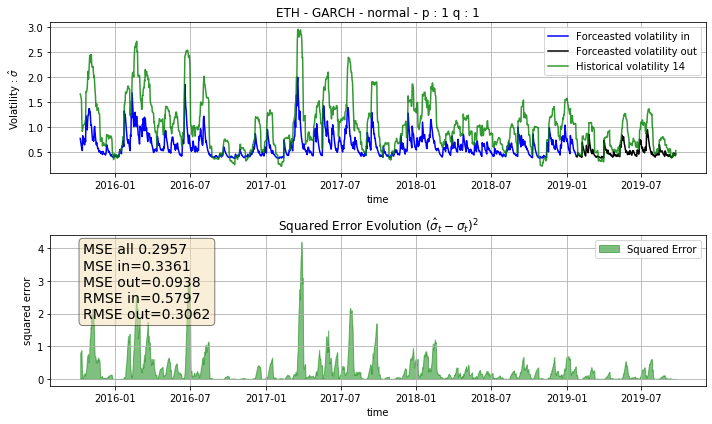

../../paper/img/forecasts/ts/ETH/ETH-GARCH-normal-1-1.png


In [72]:
compute_mse_and_volatility("GARCH",'normal',ETH,1,1)

start_date 2017-08-14 00:00:00


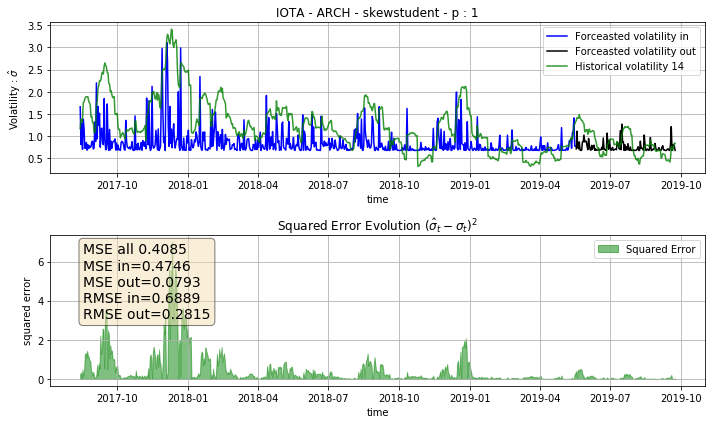

../../paper/img/forecasts/ts/IOTA/IOTA-ARCH-skewstudent-1-1.png


In [78]:
compute_mse_and_volatility("ARCH",'skewstudent',IOTA,1,1)

start_date 2017-08-14 00:00:00


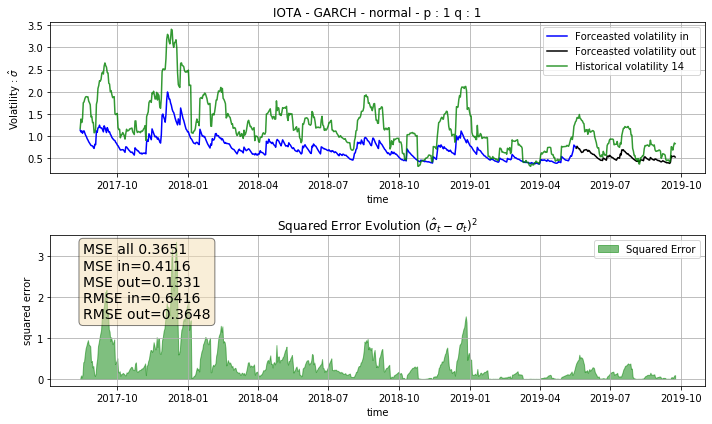

../../paper/img/forecasts/ts/IOTA/IOTA-GARCH-normal-1-1.png


In [74]:
compute_mse_and_volatility("GARCH",'normal',IOTA,1,1)

start_date 2017-09-01 00:00:00


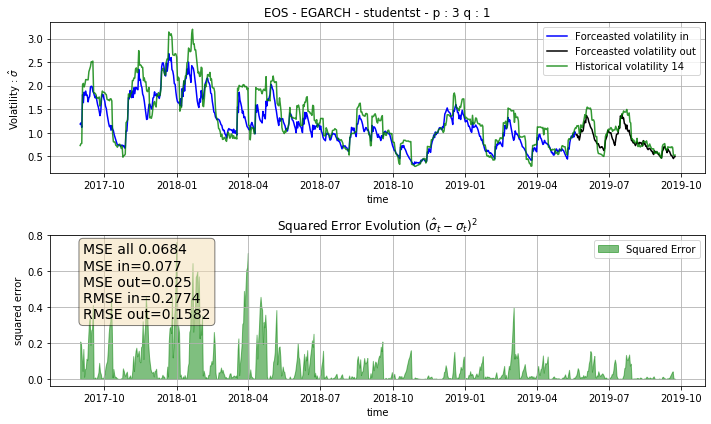

../../paper/img/forecasts/ts/EOS/EOS-EGARCH-studentst-3-1.png


In [83]:
compute_mse_and_volatility("EGARCH",'studentst',EOS,3,1)

In [5]:
compute_mse_and_volatility("GARCH",'normal',EOS,1,1)

NameError: name 'EOS' is not defined

In [6]:
import pandas as pd
import numpy as np
from arch import arch_model
import datetime as dt
from libraries.Cryptov2 import Cryptocurrency
import pandas as pd
import numpy as np
import datetime
import arch
import matplotlib.pyplot as plt
from arch.univariate import arch_model
from arch.univariate import ARCH, GARCH, EGARCH, MIDASHyperbolic
from arch.univariate import ConstantMean, ZeroMean
from arch.univariate import Normal, SkewStudent, StudentsT
%matplotlib inline

In [7]:
data = pd.read_html('https://coinmarketcap.com/currencies/eos/historical-data/?start=20130428&end=20191001')[2]

In [8]:
class Crypto:
    def __init__(self, data):
        self.name="EOS"
        self.data = data
        self.data.index = pd.to_datetime(self.data['Date'])
        self.data = self.data.drop('Date', axis=1)
        self.data.columns = ['open', 'high', 'low', 'close', 'volume', 'market_cap']
        self.data.sort_index(inplace=True)

In [74]:
EOS = Crypto(data)

In [76]:
crypto_list = [EOS]

In [77]:
 for each in crypto_list:
    each.data['log_price'] = np.log(each.data['close'])
    each.data['pct_change'] = each.data['log_price'].diff()
    each.data['stdev14'] = each.data['pct_change'].rolling(window=14, center=False).std(ddof=0)
    each.data['stdev30'] = each.data['pct_change'].rolling(window=30, center=False).std(ddof=0)
    each.data['stdev60'] = each.data['pct_change'].rolling(window=60, center=False).std(ddof=0)

    each.data['hvol14'] = each.data['stdev14'] * (365**0.5) # Annualize.
    each.data['hvol30'] = each.data['stdev30'] * (365**0.5) # Annualize.
    each.data['hvol60'] = each.data['stdev60'] * (365**0.5) # Annualize.

    each.data['variance14'] = each.data['hvol14']**2
    each.data['variance30'] = each.data['hvol30']**2
    each.data['variance60'] = each.data['hvol60']**2

    each.data = each.data.dropna() # Remove rows with blank cells.
    each.data['returns'] = each.data['pct_change'] * 100
    each.data = each.data.dropna()

In [1]:
def compute_mse_and_volatility(vol_model,dist,crypto,p,q):
    """Compute MSE and volatility
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import datetime as dt
    
    n_days = len(crypto.data.index) * 5 // 6
    last_date = dt.datetime(crypto.data.index[n_days].year,crypto.data.index[n_days].month,crypto.data.index[n_days].day)
    start_date = dt.datetime(crypto.data.index[0].year,crypto.data.index[0].month,crypto.data.index[0].day)
    print(f"start_date {start_date}")
    
    returns = crypto.data['returns']

    am = ConstantMean(returns)
    
    # Our distribution
    if dist is 'normal':
        am.distribution = Normal()
    elif dist is 'studentst':
        am.distribution = StudentsT()
    elif dist is 'skewstudent':
        am.distribution = SkewStudent()

    # Our volatility process
    if vol_model is "ARCH":
        am.volatility = ARCH(p=p)
    elif vol_model is "GARCH":
        am.volatility = GARCH(p=p, q=q)
    elif vol_model is "EGARCH":
        am.volatility = EGARCH(p=p, q=q)
    
    
    # We plot the series 
    x2 = crypto.data['hvol14']
    x3 = crypto.data['hvol30']
    x4 = crypto.data['hvol60']

    res = am.fit(disp="off", last_obs=last_date)
    forecasts = res.forecast(horizon=1, start=start_date, method='analytic')
    
    x1 = np.sqrt(0.01*forecasts.variance)
    x1 = x1['h.1']
    t1 = x1.index
    t2 = x2.index
    
    squared_error = (x1-x2)**2
    
    MSE_in = squared_error[:last_date].mean()
    MSE_out = squared_error[last_date:].mean()
    RMSE_in = np.sqrt(squared_error[:last_date].mean())
    RMSE_out = np.sqrt(squared_error[last_date:].mean())
    
    
    fig, axs = plt.subplots(2, 1, figsize=(10,6))
    
    textstr = f'MSE all {round(np.mean((x1-x2)**2),4)}\nMSE in={round(MSE_in,4)}\nMSE out={round(MSE_out,4)}\nRMSE in={round(RMSE_in,4)}\nRMSE out={round(RMSE_out,4)}'

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    axs[1].text(0.05, 0.95, textstr, transform=axs[1].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

    axs[0].set_title(f'{crypto.name} - {vol_model} - {dist} - p : {p} q : {q}')
    axs[0].plot(t1[:n_days],x1[:n_days], label='Forceasted volatility in', color="blue")
    axs[0].plot(t1[n_days:],x1[n_days:], label='Forceasted volatility out', color="black")
    axs[0].plot(t2,x2, label='Historical volatility 14 ', color="green", alpha=0.8)
    
    axs[0].set_xlabel('time')
    axs[0].set_ylabel('Volatility : $\hat{\sigma}$')
    axs[0].grid(True)
    axs[0].legend()

    axs[1].set_title('Squared Error Evolution $(\hat{\sigma}_{t}-\sigma_{t})^2$')
    axs[1].fill_between(t1, squared_error, label='Squared Error', color="green", alpha=0.5)
    axs[1].set_xlabel('time')
    axs[1].set_ylabel('squared error')
    axs[1].grid(True)
    axs[1].legend()

    fig.tight_layout()
    plt.savefig(f"../../paper/img/forecasts/ts/{crypto.name}/{crypto.name}-{vol_model}-{dist}-{p}-{q}.png")
    plt.show()
    MSE_in_rep = np.repeat(MSE_in, len(x1))
    MSE_out_rep = np.repeat(MSE_out, len(x1))
    RMSE_in_rep = np.repeat(RMSE_in, len(x1))
    RMSE_out_rep = np.repeat(RMSE_out, len(x1))

    print(f"../../paper/img/forecasts/ts/{crypto.name}/{crypto.name}-{vol_model}-{dist}-{p}-{q}.png")
    df.to_csv(f"./models/ts/forecasts/{crypto.name}/{crypto.name}-{vol_model}-{dist}-{p}-{q}.csv")

start_date 2017-08-30 00:00:00


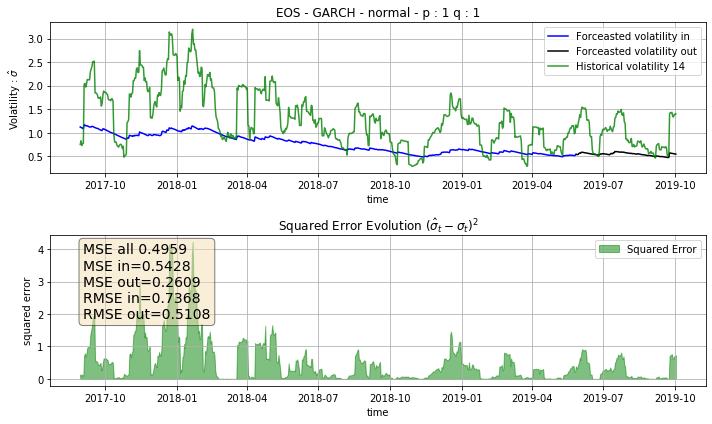

../../paper/img/forecasts/ts/EOS/EOS-GARCH-normal-1-1.png


In [98]:
compute_mse_and_volatility("GARCH","normal",EOS,1,1)